In [1]:
#pip install typing-extensions==3.7.4.1

In [2]:
!pip install webrtcvad
import contextlib
import numpy as np
import wave
import librosa
import webrtcvad


def read_wave(path):
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


class Frame(object):
  def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

In [3]:
def frame_generator(frame_duration_ms, audio, sample_rate):
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(vad, frames, sample_rate):
    is_speech = []
    for frame in frames:
        is_speech.append(vad.is_speech(frame.bytes, sample_rate))
    return is_speech


def vad(file):
    audio, sample_rate = read_wave(file)
    vad = webrtcvad.Vad(2)
    frames = frame_generator(10, audio, sample_rate)
    frames = list(frames)
    segments = vad_collector(vad, frames, sample_rate)
    return segments

In [4]:
def speech(file):
  dummy = 0
  data = []
  segments = vad(file)
  audio, sr = librosa.load(file)
  for i in segments:
    if i == True:
      data.append(audio[dummy:dummy + 480])
      dummy = dummy + 480
    else:
      dummy = dummy + 480
  data = np.ravel(np.asarray(data))

  return data

def fxn(file):
  segments = vad(file)
  segments = np.asarray(segments)
  dummy = 0.01*np.where(segments[:-1] != segments[1:])[0] +.01
  if len(dummy)%2==0:
    dummy = dummy
  else:
    dummy = np.delete(dummy, len(dummy)-1)

  voice = dummy.reshape(int(len(dummy)/2),2)

  return voice

In [5]:
!pip install tensorflow

In [33]:
import warnings
warnings.filterwarnings("ignore")
file_list = ['Hindi1_01', 'Hindi1_02', 'Hindi1_03']



def extract_feature(file_name):
    file = "/content/" + file_name + ".wav"
    frame_size = 2048
    frame_shift = 512
    y, sr = librosa.load(file)
    #MFCC Extraction
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12, hop_length=frame_shift, n_fft=frame_size)
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)

    mfcc = mfccs[1:, ]
    norm_mfcc = (mfcc - np.mean(mfcc, axis=1, keepdims=True)) / np.std(mfcc, axis=1, keepdims=True)
    norm_mfcc_delta = (mfcc_delta - np.mean(mfcc_delta, axis=1, keepdims=True)) / np.std(mfcc_delta, axis=1, keepdims=True)
    norm_mfcc_delta2= (mfcc_delta2 - np.mean(mfcc_delta2, axis=1, keepdims=True)) / np.std(mfcc_delta2, axis=1, keepdims=True)

    ac_feature = np.vstack((norm_mfcc, norm_mfcc_delta, norm_mfcc_delta2))

 #Loading Annotation File
    ann = pd.read_csv('/content/annotations1 (1).csv')
    ann['End_point'] = ann['Duration'] + ann['Offset']

    change_point = []
    for i in range(len(ann['End_point'])):
        dur_1 = int((ann['End_point'][i]-0.075)*sr)  # left 50ms
        dur_2 = int((ann['End_point'][i]+0.075)*sr)  # right 50ms
        change_point.append((dur_1, dur_2))

    sub_seq_len = int(3.2*sr/frame_shift)
    sub_seq_step= int(0.8*sr/frame_shift)

    feature_len = ac_feature.shape[1]

    def is_change_point(n):
        flag = False
        for x in change_point:
            if n > x[0] and n < x[1]:
                flag = True
                break

            if n+frame_size-1 > x[0] and n+frame_size-1 < x[1]:
                flag = True
                break
        return flag

    sub_train_x = []
    sub_train_y = []
    for i in range(0, feature_len-sub_seq_len, sub_seq_step):
        sub_seq_x = np.transpose(ac_feature[:, i: i+sub_seq_len])
        sub_train_x.append(sub_seq_x[np.newaxis, :, :])
        tmp = []
        for index in range(i, i+sub_seq_len):
            if is_change_point(index*frame_shift):
                tmp.append(1)
            else:
                tmp.append(0)
        lab_y = np.array(tmp)
        lab_y = np.reshape(lab_y, (1, sub_seq_len))
        sub_train_y.append(lab_y)
    return sub_train_x, sub_train_y


def load_dataset():
    all_x = []
    all_y = []
    for audio_file in file_list:
        new_train_x, new_train_y = extract_feature(audio_file)
        new_train_x = np.vstack(new_train_x)
        new_train_y = np.vstack(new_train_y)
        print(new_train_x.shape)
        print(new_train_y.shape)

        all_x.append(new_train_x)
        all_y.append(new_train_y)
    print(len(all_x))
    print(len(all_y))

    all_x_stack = np.vstack(all_x)
    all_y_stack = np.vstack(all_y)
    print(all_x_stack.shape, all_y_stack.shape)
    print('over')
    return all_x_stack, all_y_stack

In [34]:
#from keras.legacy import interfaces
from keras.optimizers import Optimizer
from keras import backend as K
#SNORM Optimizer
#class SMORMS3(Optimizer):

In [38]:
def train_bilstm():

    model = Sequential()

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(32)))
    model.add(TimeDistributed(Dense(32)))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))

    model.build(input_shape=(None, 137, 35))

    model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])
    model.summary()

    all_x, all_y = load_dataset()
    print(all_y.shape, np.sum(all_y))

    subsample_all_x = []
    subsample_all_y = []
    for index in range(all_y.shape[0]):
        class_positive = sum(all_y[index])
        if class_positive > 5:
            subsample_all_x.append(all_x[index][np.newaxis, :, :])
            subsample_all_y.append(all_y[index])

    all_x = np.vstack(subsample_all_x)
    all_y = np.vstack(subsample_all_y)
    print(all_y.shape, np.sum(all_y))
    all_y = all_y[:, :, np.newaxis]

    indices = np.random.permutation(all_x.shape[0])
    all_x_random = all_x[indices]
    all_y_random = all_y[indices]

    datasize = all_x_random.shape[0]
    train_size = int(datasize*0.97)
    train_x = all_x_random[0:train_size]
    valid_x = all_x_random[train_size:]

    train_y = all_y_random[0:train_size]
    valid_y = all_y_random[train_size:]
    print('train over')

    my = model.fit(x=train_x, y=train_y, batch_size=256, epochs=50,
              validation_data=(valid_x, valid_y), shuffle=True)
    model.save('/content/model_hindi_2.h5')
    def save_model(model, json_model_file, h5_model_file):
        # serialize model to JSON
        model_json = model.to_json()
        with open(json_model_file, "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights(h5_model_file)
        print("Saved model to disk")

    model_name = 'speech_seg1'
    json_model_file = '/content/model_hindi_2'+'.json'
    h5_model_file = '/content/model_hindi_2'+'.h5'
    save_model(model, json_model_file, h5_model_file)

In [39]:
import pandas as pd
train_bilstm()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_16 (Bidirectional)     │ (None, 137, 256)            │         167,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 137, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 137, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 137, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 137, 32)             │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 137, 32)             │           1,056 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_26                  │ (None, 137, 1)              │              33 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 571,489 (2.18 MB)

 Trainable params: 571,489 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

(1523, 137, 35)
(1523, 137)
(1523, 137, 35)
(1523, 137)
(1643, 137, 35)
(1643, 137)
3
3
(4689, 137, 35) (4689, 137)
over
(4689, 137) 6883
(598, 137) 6694
train over
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - accuracy: 0.5951 - loss: 0.6657 - val_accuracy: 0.9213 - val_loss: 0.4345
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.9092 - loss: 0.3966 - val_accuracy: 0.9213 - val_loss: 0.3099
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.9180 - loss: 0.3133 - val_accuracy: 0.9112 - val_loss: 0.3015
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9070 - loss: 0.3143 - val_accuracy: 0.9213 - val_loss: 0.2756
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.9191 - loss: 0.2749 - val_accuracy: 0.9213 - val_loss: 0.2786
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.9184 - loss: 0.2795 - val_accuracy: 0.9213 - val_loss: 0.2785
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.9177 - loss: 0.2803 - val_acc

ValueError: The filename must end in `.weights.h5`. Received: filepath=/content/model_hindi_2.h5

In [40]:
import tensorflow
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import *
from keras.models import *
import librosa
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Bidirectional, TimeDistributed, Dropout
from keras.layers import LSTM
import numpy as np
import keras

model = Sequential()

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(32)))
model.add(TimeDistributed(Dense(32)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

model.build(input_shape=(None, 137, 35))
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_18 (Bidirectional)     │ (None, 137, 256)            │         167,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_19 (Bidirectional)     │ (None, 137, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, 137, 32)             │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, 137, 32)             │           1,056 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 137, 1)              │              33 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 571,489 (2.18 MB)

 Trainable params: 571,489 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.load_weights("/content/model_hindi_2.h5")

In [42]:
def multi_segmentation(file):
    frame_size = 2048
    frame_shift = 512
    y, sr = librosa.load(file)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12, hop_length=frame_shift, n_fft=frame_size)
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)

    mfcc = mfccs[1:, ]
    norm_mfcc = (mfcc - np.mean(mfcc, axis=1, keepdims=True)) / np.std(mfcc, axis=1, keepdims=True)
    norm_mfcc_delta = (mfcc_delta - np.mean(mfcc_delta, axis=1, keepdims=True)) / np.std(mfcc_delta, axis=1, keepdims=True)
    norm_mfcc_delta2 = (mfcc_delta2 - np.mean(mfcc_delta2, axis=1, keepdims=True)) / np.std(mfcc_delta2, axis=1, keepdims=True)

    ac_feature = np.vstack((norm_mfcc, norm_mfcc_delta, norm_mfcc_delta2))
    print(ac_feature.shape)

    sub_seq_len = int(3.2 * sr / frame_shift)
    sub_seq_step = int(0.8 * sr / frame_shift)

    def extract_feature():
        feature_len = ac_feature.shape[1]
        sub_train_x = []
        for i in range(0, feature_len-sub_seq_len, sub_seq_step):
            sub_seq_x = np.transpose(ac_feature[:, i: i+sub_seq_len])
            sub_train_x.append(sub_seq_x[np.newaxis, :, :])
        return np.vstack(sub_train_x), feature_len

    predict_x, feature_len = extract_feature()
    print(predict_x.shape)

    predict_y = model.predict(predict_x)
    print(predict_y.shape)

    score_acc = np.zeros((feature_len, 1))
    score_cnt = np.ones((feature_len, 1))

    for i in range(predict_y.shape[0]):
        for j in range(predict_y.shape[1]):
            index = i*sub_seq_step+j
            score_acc[index] += predict_y[i, j, 0]
            score_cnt[index] += 1

    score_norm = score_acc / score_cnt

    wStart = 0
    wEnd = 200
    wGrow = 200
    delta = 25

    store_cp = []
    index = 0
    while wEnd < feature_len:
        score_seg = score_norm[wStart:wEnd]
        max_v = np.max(score_seg)
        max_index = np.argmax(score_seg)
        index = index + 1
        if max_v > 0.5:
            temp = wStart + max_index
            store_cp.append(temp)
            wStart = wStart + max_index + 50
            wEnd = wStart + wGrow
        else:
            wEnd = wEnd + wGrow

    seg_point = np.array(store_cp)*frame_shift

    plt.figure('speech segmentation plot')
    plt.plot(np.arange(0, len(y)) / (float)(sr), y, "b-")

    for i in range(len(seg_point)):
        plt.vlines(seg_point[i] / (float)(sr), -1, 1, colors="c", linestyles="dashed")
        plt.vlines(seg_point[i] / (float)(sr), -1, 1, colors="r", linestyles="dashed")
    plt.xlabel("Time/s")
    plt.ylabel("Speech Amp")
    plt.grid(True)
    plt.show()

    return np.asarray(seg_point) / float(sr)

In [43]:
def group_intervals(a):
    a = a.tolist()
    ans = []

    curr = None
    for x in a:
        # no previous interval under consideration
        if curr == None:
          curr = x
        else:
            # check if we can merge the intervals
            if x[0]-curr[1] < 1:
                curr[1] = x[1]
            else:
            # if we cannot merge, push the current element to ans
                ans.append(curr)
                curr = x

        if curr is not None:
            ans.append(curr)

    d1 = np.asarray(ans)
    d2 = np.unique(d1)
    d3 = d2.reshape(int(len(d2)/2),2)
    return d3

In [44]:
def spliting(seg,arr):
  arr1 = arr.tolist()
  temp = arr.copy()

  for i in range(len(seg)-1):
    temp1 = float(seg[i])
    # print(temp1)
    #for j in range(len(arr)-1):
    for j in range(len(arr)):
      if ((temp1 > arr[j][0]) & (temp1 < arr[j][1])):
        arr1[j].insert(-1,(temp1))

  #for i in range(len(arr1-1)):
  for i in range(len(arr1)):
    size=len(arr1[i])
    if size>=3:
      arr1[i].pop(-2) if arr1[i][-1]-arr1[i][-2]<0.2 else True

  return arr1

In [45]:
def final_reseg(arr):
  z=[]
  for i in arr:
    if len(i)==2:
      z.append(i)
    else:
      temp = len(i)
      for j in range(temp-1):
        if j!=temp-1:
          temp1 = [i[j],i[j+1]-0.01]
          z.append(temp1)
        elif j==temp-1:
          temp1 = [i[j],i[j+1]]
          z.append(temp1)

  return np.asarray(z)

In [46]:
!pip install pyannote.core==4.1 pyannote.pipeline==1.5.2 pyannote.audio==1.1.1
!wget -nc https://raw.githubusercontent.com/pyannote/pyannote-audio/1.1.1/hubconf.py -P /root/.cache/torch/hub/pyannote_pyannote-audio_main
import torch
import pyannote.core #https://github.com/pyannote/pyannote-audio/issues/561

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=196c00f5c9d7a3afbcdf7f9bf362039131cf54312fa0b9f860ba0a1c0c9d4698
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
--2024-08-27 15:52:05--  https://raw.

In [47]:
import torch
import librosa
from pyannote.core import Segment

def embeddings_(audio_path,resegmented,range):
  model_emb = torch.hub.load('pyannote/pyannote-audio', 'emb')

  embedding = model_emb({'audio': audio_path})
  for window, emb in embedding:
    assert isinstance(window, Segment)
    assert isinstance(emb, np.ndarray)

  y, sr = librosa.load(audio_path)
  myDict={}
  myDict['audio'] = audio_path
  myDict['duration'] = len(y)/sr

  data=[]
  for i in resegmented:
    excerpt = Segment(start=i[0], end=i[0]+range)
    emb = model_emb.crop(myDict,excerpt)
    data.append(emb.T)
  data= np.asarray(data)

  return data.reshape(len(data),512)

In [48]:
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
scaler = StandardScaler()
def clustering(emb):
  temp = scaler.fit_transform(emb)
  Y = TSNE(n_components=2).fit_transform(temp)
  cluster_ms = MeanShift(bandwidth = 3,max_iter=200,cluster_all=False).fit(Y)
  y_ms = cluster_ms.predict(Y)
  clus_centre = cluster_ms.cluster_centers_
  n_speakers = clus_centre.shape[0]
  plt.figure
  plt.scatter(Y[:,0], Y[:, 1], c=y_ms, s=50, cmap='viridis')
  plt.show()

  return y_ms, n_speakers

In [49]:
from pyannote.core import Annotation, Segment
def hypothesis_gen(hyp_df):
  hyp_records = hyp_df.to_records(index=False)
  hyp_rec = list(hyp_records)
  hypothesis = Annotation()
  for i in range(len(hyp_rec)-1):
    hypothesis[Segment(hyp_rec[i][1], hyp_rec[i][2])] = hyp_rec[i][0]

  return hypothesis

In [50]:
from sklearn import preprocessing
import pandas as pd
def diarization(audiofile):
    voice = fxn(audiofile)
    segmented = multi_segmentation(audiofile)
    gp = group_intervals(voice)
    splt = spliting(segmented,gp)
    resegmented = final_reseg(splt)
    embeddings = embeddings_(audiofile,resegmented,2)
    speak_id , n_speakers = clustering(embeddings)
    label_list = []
    alpha = 'A'
    for i in range(0, n_speakers):
        label_list.append(alpha)
        alpha = chr(ord(alpha) + 1)
    lb = preprocessing.LabelEncoder()
    label_hyp = lb.fit(label_list)
    speaker_id = lb.inverse_transform(speak_id)
    hyp_df = pd.DataFrame({'Speaker_id': speaker_id,'Offset': resegmented[:, 0], 'end': resegmented[:, 1]})
    result_hypo = hypothesis_gen(hyp_df)
    return segmented, n_speakers, hyp_df, result_hypo

In [51]:
!ffmpeg -n -i Hindi1_02.wav -ac 1 mono_hindi2.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [52]:
!ffmpeg -i mono_hindi2.wav -ar 16000 hindi2.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
#!pip install librosa --upgrade

In [53]:
!pip install pyannote.audio.features

ERROR: Could not find a version that satisfies the requirement pyannote.audio.features (from versions: none)
ERROR: No matching distribution found for pyannote.audio.features


(35, 51912)
(1523, 137, 35)
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 561ms/step
(1523, 137, 1)


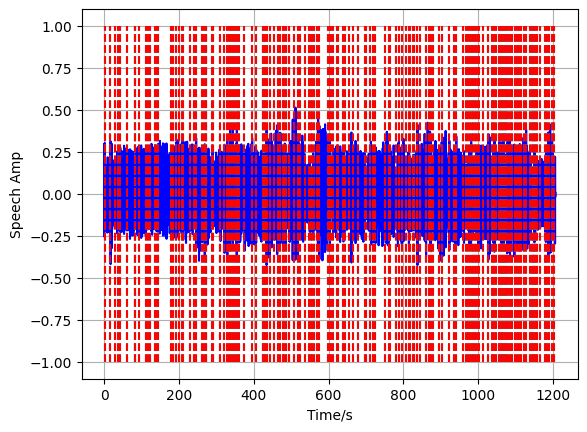

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_main


100%|██████████| 901/901 [00:00<00:00, 495kB/s]


100%|██████████| 16.3M/16.3M [00:00<00:00, 89.9MB/s]


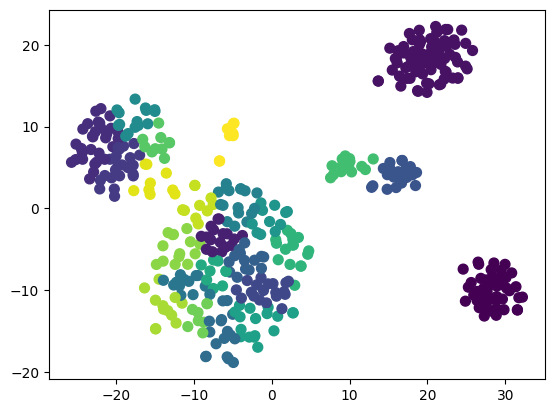

24
    Speaker_id       Offset          end
0            X     0.260000     3.194354
1            Q     3.204354     7.520000
2            A    15.550000    15.560000
3            A    19.450000    19.690000
4            A    22.870000    24.740000
..         ...          ...          ...
441          V  1192.010000  1192.120000
442          T  1193.730000  1193.990000
443          H  1195.240000  1195.300000
444          I  1197.840000  1198.130000
445          F  1203.380000  1203.600000

[446 rows x 3 columns]


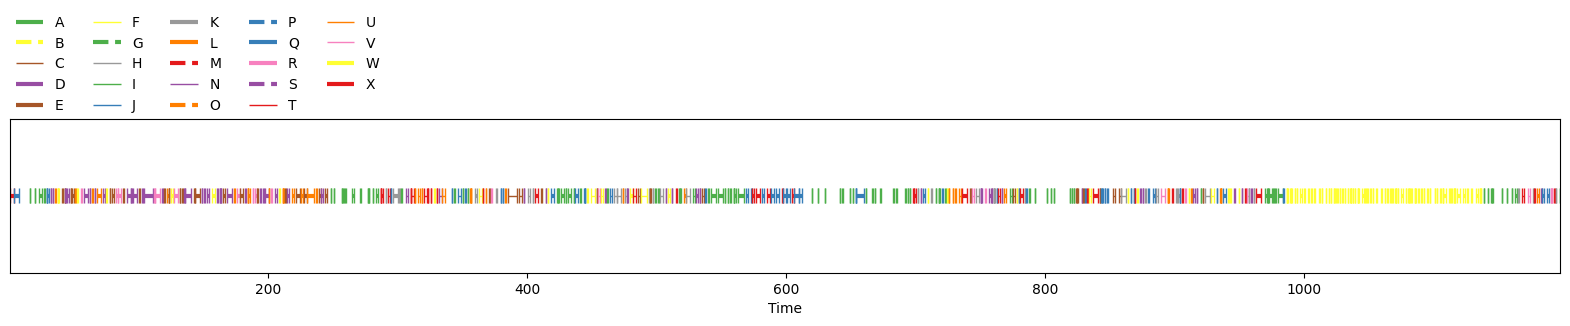

In [54]:
segmented, n_clusters, hyp_df, result_hypo = diarization("hindi2.wav")
print(n_clusters)
print(hyp_df)
result_hypo

In [55]:
def reference_gen(annotation_path):
  df = pd.read_csv(annotation_path)
  ref_df = df[df['filename'] == 'Hindi1_02']
  ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
  ref_df = ref_df[['Speaker_id','Offset','end']]
  ref_records = ref_df.to_records(index=False)
  ref_rec = list(ref_records)
  reference = Annotation()
  for i in range(len(ref_rec)-1):
    reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

  return reference, ref_df

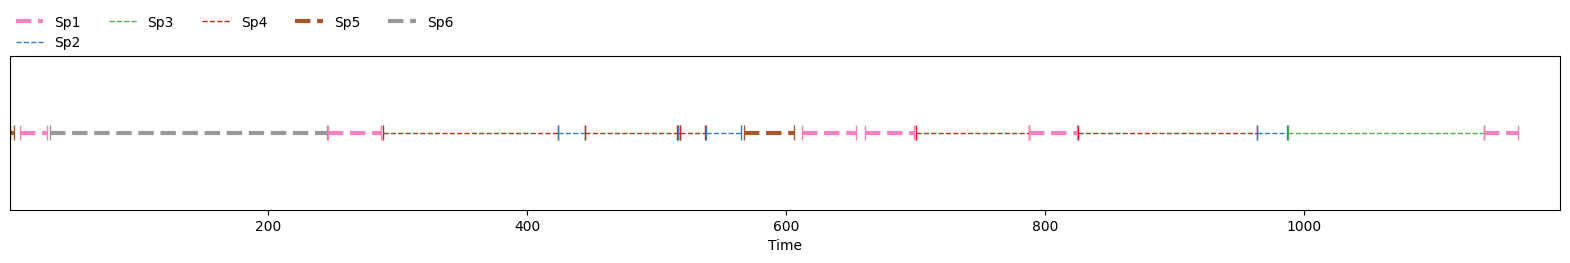

In [56]:
reference, ref_df = reference_gen('/content/annotations1 (1).csv')
#Visualization (Comparing Between Ground Truth and Hypothesis)
reference

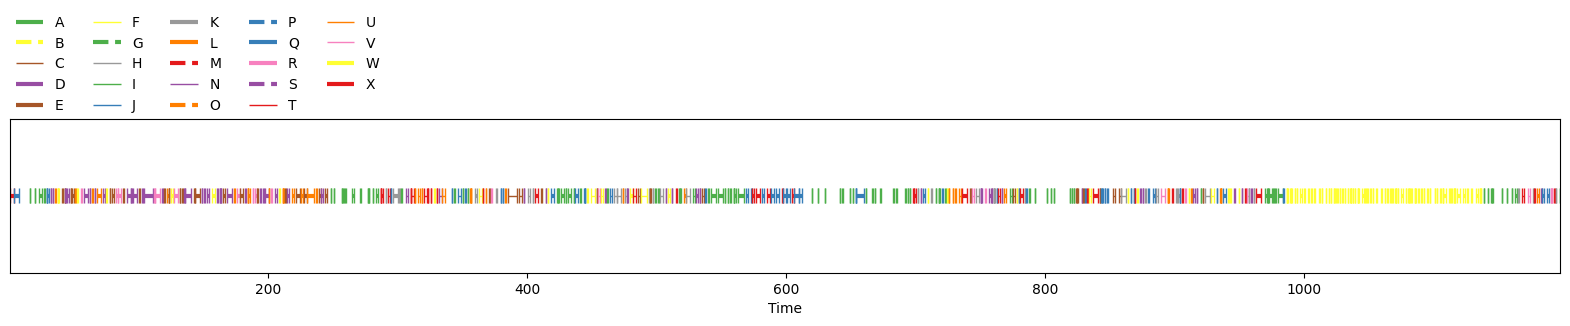

In [57]:
result_hypo

In [58]:
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.metrics.diarization import DiarizationPurity
from pyannote.metrics.diarization import DiarizationCoverage
#Upload the annotation file from Google Drive. Change the Path accordingly.
result_ref, ref_df = reference_gen('/content/annotations1 (1).csv')
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(result_ref, result_hypo)))
#To Evaluate particular Segment of audio-file.
diarizationErrorRate(result_ref, result_hypo, detailed=True, uem=Segment(0, 40))
#Purity
purity = DiarizationPurity()
print("Purity = {0:.3f}".format(purity(result_ref, result_hypo, uem=Segment(0, 40))))
#Coverage
coverage = DiarizationCoverage()
print("Coverage = {0:.3f}".format(coverage(result_ref, result_hypo, uem=Segment(0, 40))))

DER = 0.894
Purity = 0.993
Coverage = 0.864


In [59]:
!ffmpeg -n -i Hindi1_03.wav -ac 1 mono_hindi3.wav
!ffmpeg -i mono_hindi3.wav -ar 16000 hindi3.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

(35, 55990)
(1643, 137, 35)
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 452ms/step
(1643, 137, 1)


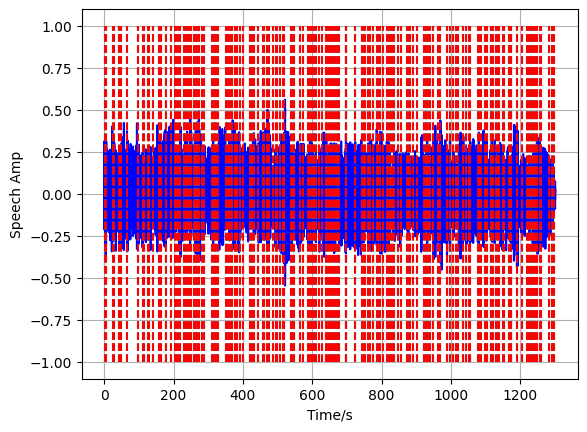

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_main


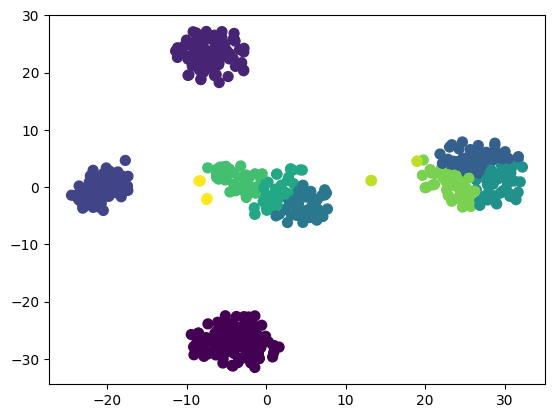

11
    Speaker_id       Offset          end
0            D     0.070000     1.360000
1            I     3.430000     3.710000
2            F     5.130000     5.240000
3            F     8.120000     8.520000
4            I    12.900000    14.070000
..         ...          ...          ...
482          C  1280.750000  1281.010000
483          C  1282.330000  1282.460000
484          C  1283.500000  1283.680000
485          B  1290.680000  1291.878617
486          B  1291.888617  1299.410000

[487 rows x 3 columns]


In [60]:
segmented, n_clusters, hyp_df, result_hypo = diarization("hindi3.wav")
print(n_clusters)
print(hyp_df)
result_hypo

def reference_gen(annotation_path):
  df = pd.read_csv(annotation_path)
  ref_df = df[df['filename'] == 'Hindi1_03']
  ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
  ref_df = ref_df[['Speaker_id','Offset','end']]
  ref_records = ref_df.to_records(index=False)
  ref_rec = list(ref_records)
  reference = Annotation()
  for i in range(len(ref_rec)-1):
    reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

  return reference, ref_df

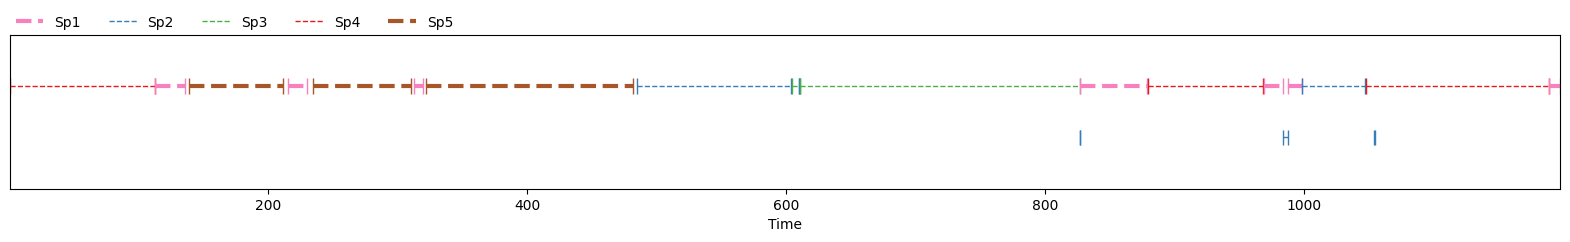

In [61]:
reference, ref_df = reference_gen('/content/annotations1 (1).csv')
#Visualization (Comparing Between Ground Truth and Hypothesis)
reference
##meta heurisstics working and techniques, current sota
##cancer detection
##meta heuristics current sota, criticial analysis (current limitations and scope)
##explainable solutions to cancer detection current sota


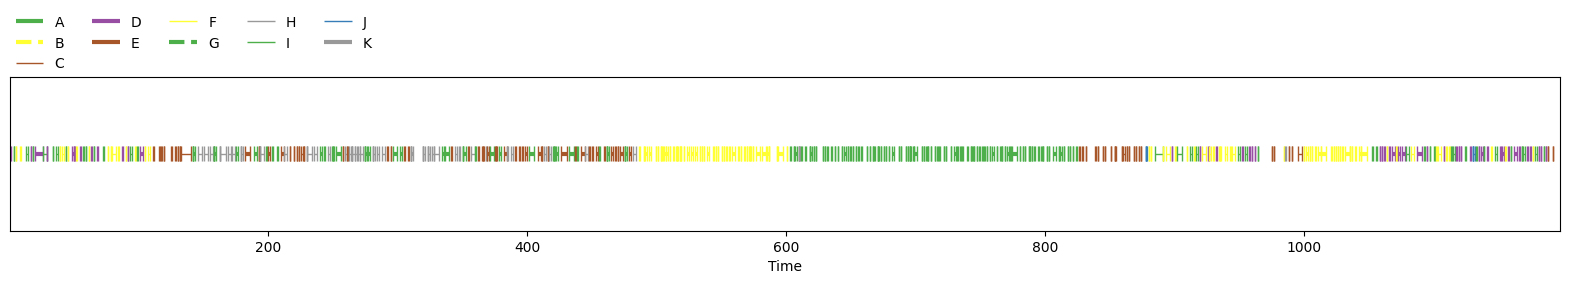

In [62]:
result_hypo

In [63]:
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.metrics.diarization import DiarizationPurity
from pyannote.metrics.diarization import DiarizationCoverage
#Upload the annotation file from Google Drive. Change the Path accordingly.
result_ref, ref_df = reference_gen('/content/annotations1 (1).csv')
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(result_ref, result_hypo)))
#To Evaluate particular Segment of audio-file.
diarizationErrorRate(result_ref, result_hypo, detailed=True, uem=Segment(0, 40))
#Purity
purity = DiarizationPurity()
print("Purity = {0:.3f}".format(purity(result_ref, result_hypo, uem=Segment(0, 40))))
#Coverage
coverage = DiarizationCoverage()
print("Coverage = {0:.3f}".format(coverage(result_ref, result_hypo, uem=Segment(0, 40))))

DER = 0.830
Purity = 1.000
Coverage = 0.549


In [64]:
!ffmpeg -n -i Hindi1_01.wav -ac 1 mono_hindi1.wav
!ffmpeg -i mono_hindi1.wav -ar 16000 hindi1.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

(35, 51912)
(1523, 137, 35)
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 410ms/step
(1523, 137, 1)


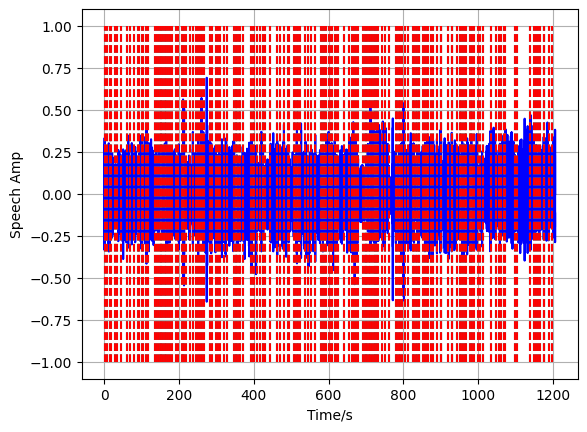

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_main


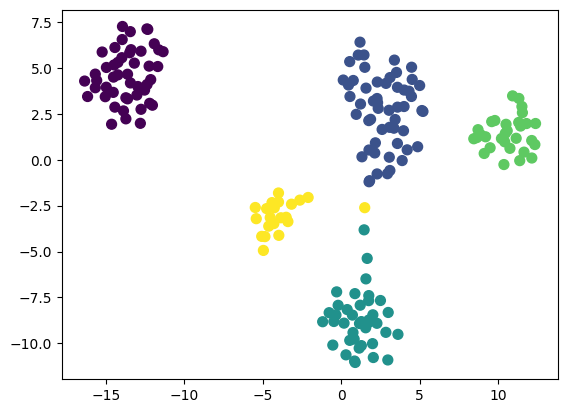

5
    Speaker_id       Offset          end
0            E     0.040000     3.147914
1            E     3.157914     8.511723
2            E     8.521723    16.174308
3            E    16.184308    17.381746
4            E    17.391746    28.759524
..         ...          ...          ...
186          B  1178.480000  1179.470000
187          B  1181.060000  1186.170000
188          B  1187.830000  1189.780476
189          B  1189.790476  1202.110000
190          B  1203.130000  1204.180000

[191 rows x 3 columns]


In [65]:
segmented, n_clusters, hyp_df, result_hypo = diarization("hindi1.wav")
print(n_clusters)
print(hyp_df)
result_hypo

def reference_gen(annotation_path):
  df = pd.read_csv(annotation_path)
  ref_df = df[df['filename'] == 'Hindi1_01']
  ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
  ref_df = ref_df[['Speaker_id','Offset','end']]
  ref_records = ref_df.to_records(index=False)
  ref_rec = list(ref_records)
  reference = Annotation()
  for i in range(len(ref_rec)-1):
    reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

  return reference, ref_df

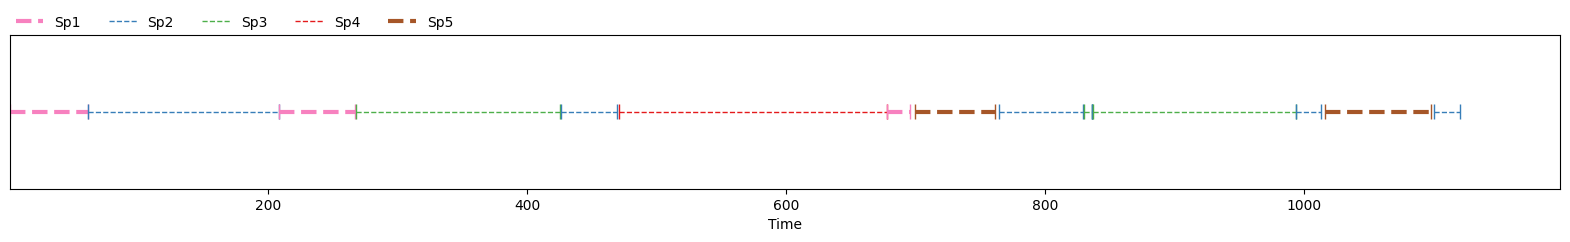

In [66]:
reference, ref_df = reference_gen('/content/annotations1 (1).csv')
#Visualization (Comparing Between Ground Truth and Hypothesis)
reference

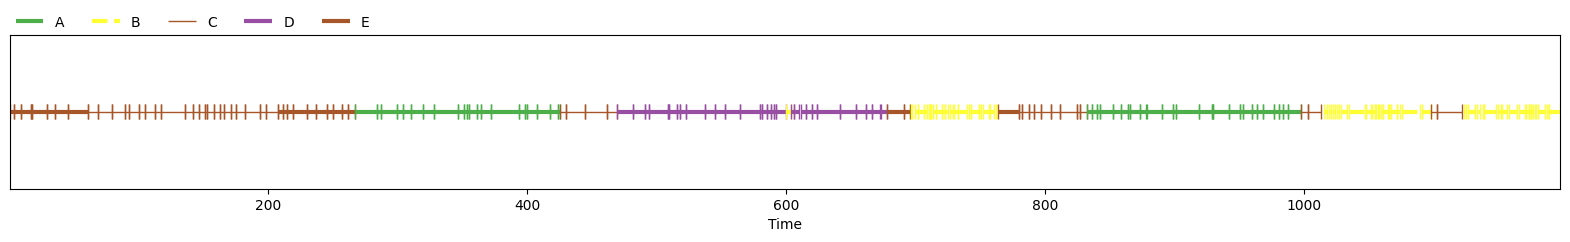

In [67]:
result_hypo

In [68]:
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.metrics.diarization import DiarizationPurity
from pyannote.metrics.diarization import DiarizationCoverage
#Upload the annotation file from Google Drive. Change the Path accordingly.
result_ref, ref_df = reference_gen('/content/annotations1 (1).csv')
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(result_ref, result_hypo)))
#To Evaluate particular Segment of audio-file.
diarizationErrorRate(result_ref, result_hypo, detailed=True, uem=Segment(0, 40))
#Purity
purity = DiarizationPurity()
print("Purity = {0:.3f}".format(purity(result_ref, result_hypo, uem=Segment(0, 40))))
#Coverage
coverage = DiarizationCoverage()
print("Coverage = {0:.3f}".format(coverage(result_ref, result_hypo, uem=Segment(0, 40))))

DER = 0.113
Purity = 1.000
Coverage = 1.000


In [69]:
!ffmpeg -n -i Hindi_01.wav -ac 1 mono_hindiA1.wav
!ffmpeg -i mono_hindiA1.wav -ar 16000 hindiA1.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

(35, 78497)
(2305, 137, 35)
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 304ms/step
(2305, 137, 1)


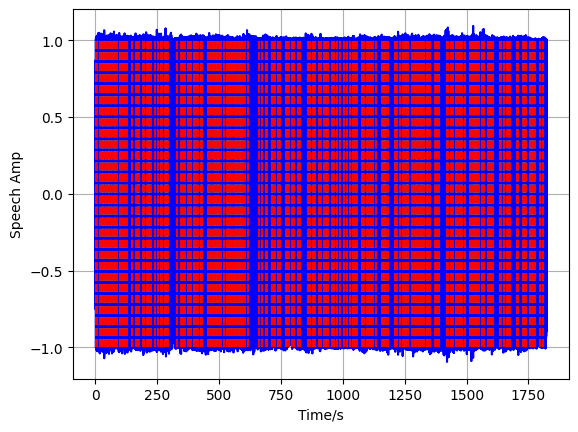

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_main


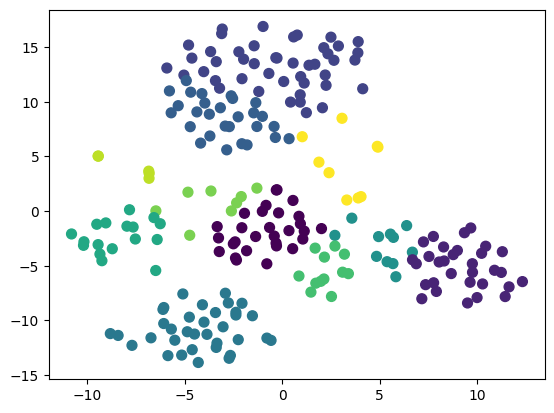

11
    Speaker_id       Offset          end
0            D     0.050000     1.615397
1            D     1.625397     6.654127
2            C     6.664127    17.590726
3            D    17.600726    26.205329
4            C    26.215329    29.966961
..         ...          ...          ...
225          G  1762.673197  1765.588912
226          G  1765.598912  1771.184921
227          G  1771.194921  1776.246871
228          G  1776.256871  1797.307370
229          G  1797.317370  1821.220000

[230 rows x 3 columns]


In [70]:
segmented, n_clusters, hyp_df, result_hypo = diarization("hindiA1.wav")
print(n_clusters)
print(hyp_df)
result_hypo

def reference_gen(annotation_path):
  df = pd.read_csv(annotation_path)
  ref_df = df[df['filename'] == 'Hindi_01']
  ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
  ref_df = ref_df[['Speaker_id','Offset','end']]
  ref_records = ref_df.to_records(index=False)
  ref_rec = list(ref_records)
  reference = Annotation()
  for i in range(len(ref_rec)-1):
    reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

  return reference, ref_df

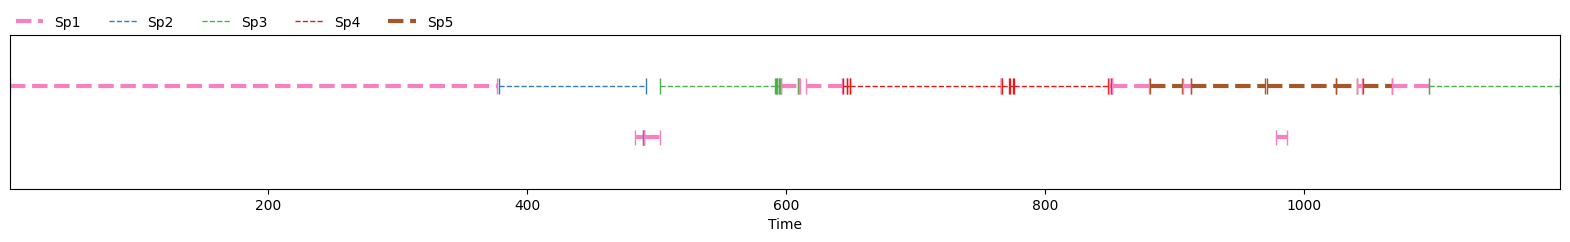

In [71]:
reference, ref_df = reference_gen('/content/hindi_annotations1.csv')
#Visualization (Comparing Between Ground Truth and Hypothesis)
reference

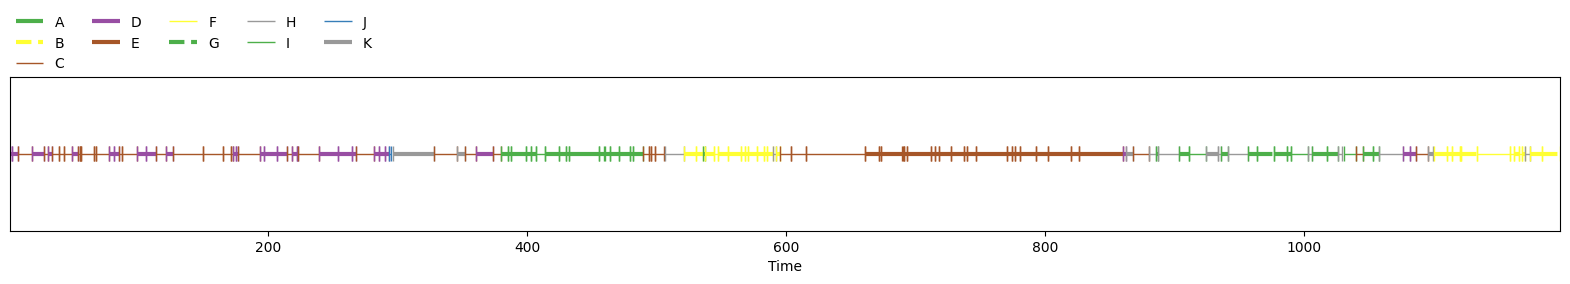

In [72]:
result_hypo

In [73]:
result_ref, ref_df = reference_gen('/content/hindi_annotations1.csv')
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(result_ref, result_hypo)))
#To Evaluate particular Segment of audio-file.
diarizationErrorRate(result_ref, result_hypo, detailed=True, uem=Segment(0, 40))
#Purity
purity = DiarizationPurity()
print("Purity = {0:.3f}".format(purity(result_ref, result_hypo, uem=Segment(0, 40))))
#Coverage
coverage = DiarizationCoverage()
print("Coverage = {0:.3f}".format(coverage(result_ref, result_hypo, uem=Segment(0, 40))))

DER = 0.401
Purity = 1.000
Coverage = 0.556


In [74]:
!ffmpeg -n -i Hindi_02.wav -ac 1 mono_hindiA2.wav
!ffmpeg -i mono_hindiA2.wav -ar 16000 hindiA2.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

(35, 76817)
(2256, 137, 35)
71/71 ━━━━━━━━━━━━━━━━━━━━ 30s 429ms/step
(2256, 137, 1)


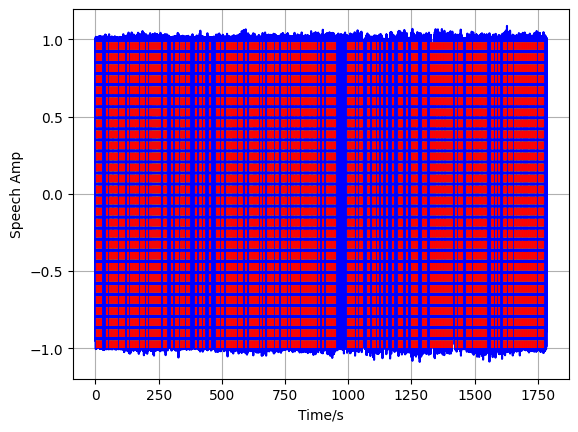

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_main


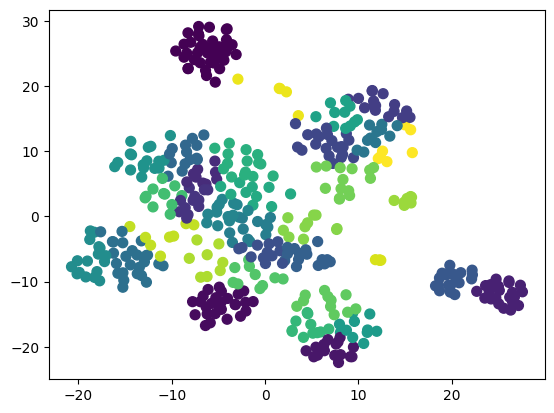

34
    Speaker_id       Offset          end
0            B     2.740000     2.830000
1            B     5.220000     5.330000
2            B     6.650000     6.654127
3            B     6.664127     8.070000
4            B    11.800000    12.320000
..         ...          ...          ...
464          P  1768.980000  1769.990000
465          L  1773.040000  1773.050000
466          P  1775.270000  1775.310000
467          N  1776.330000  1776.490000
468          V  1783.060000  1783.110000

[469 rows x 3 columns]


In [75]:
segmented, n_clusters, hyp_df, result_hypo = diarization("hindiA2.wav")
print(n_clusters)
print(hyp_df)
result_hypo

def reference_gen(annotation_path):
  df = pd.read_csv(annotation_path)
  ref_df = df[df['filename'] == 'Hindi_02']
  ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
  ref_df = ref_df[['Speaker_id','Offset','end']]
  ref_records = ref_df.to_records(index=False)
  ref_rec = list(ref_records)
  reference = Annotation()
  for i in range(len(ref_rec)-1):
    reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

  return reference, ref_df

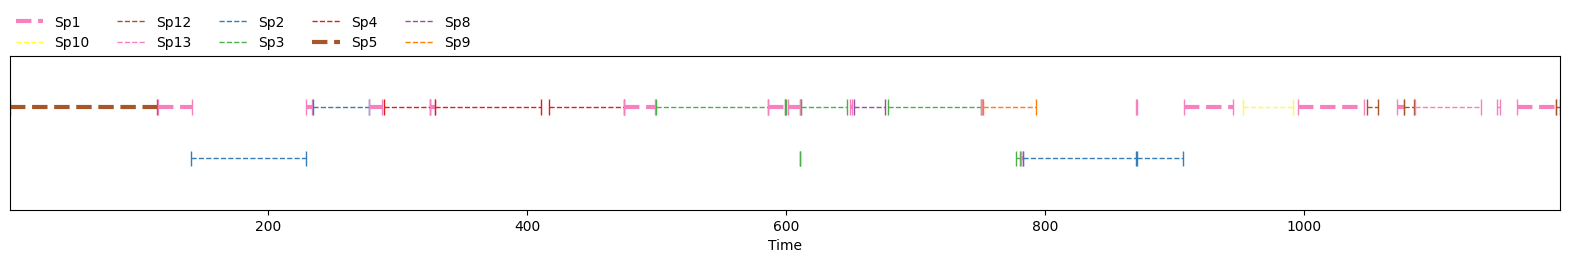

In [76]:
reference, ref_df = reference_gen('/content/hindi_annotations1.csv')
#Visualization (Comparing Between Ground Truth and Hypothesis)
reference

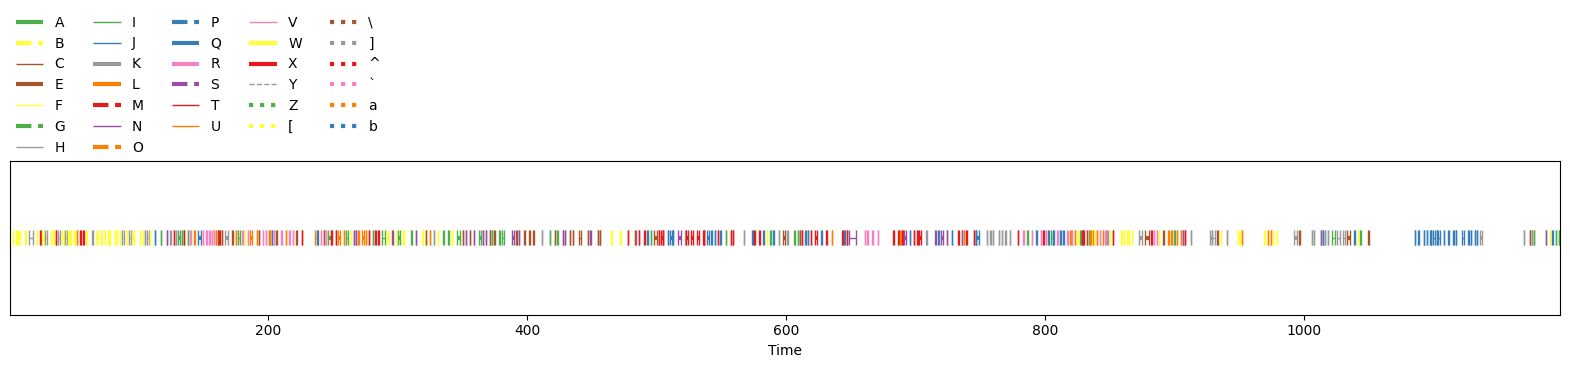

In [77]:
result_hypo

In [78]:
result_ref, ref_df = reference_gen('/content/hindi_annotations1.csv')
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(result_ref, result_hypo)))
#To Evaluate particular Segment of audio-file.
diarizationErrorRate(result_ref, result_hypo, detailed=True, uem=Segment(0, 40))
#Purity
purity = DiarizationPurity()
print("Purity = {0:.3f}".format(purity(result_ref, result_hypo, uem=Segment(0, 40))))
#Coverage
coverage = DiarizationCoverage()
print("Coverage = {0:.3f}".format(coverage(result_ref, result_hypo, uem=Segment(0, 40))))

DER = 0.964
Purity = 1.000
Coverage = 0.549


In [79]:
!ffmpeg -n -i Hindi_03.wav -ac 1 mono_hindiA3.wav
!ffmpeg -i mono_hindiA3.wav -ar 16000 hindiA3.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

(35, 23788)
(696, 137, 35)
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 346ms/step
(696, 137, 1)


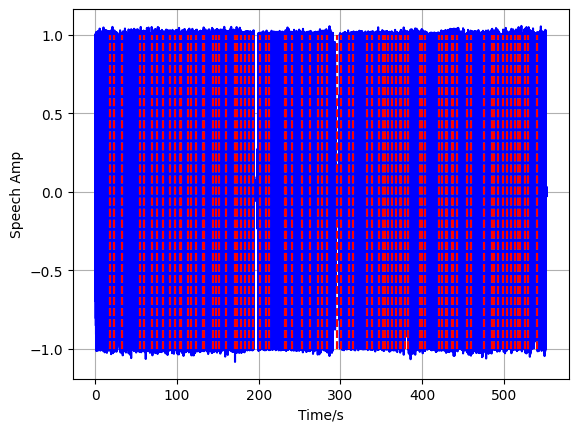

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_main


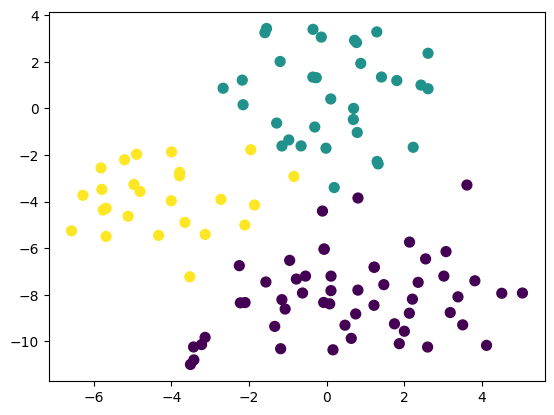

3
    Speaker_id  Offset     end
0            C    0.07    0.25
1            C    3.11    4.70
2            C    7.87   10.93
3            C   14.70   14.88
4            C   18.38   18.86
..         ...     ...     ...
106          C  402.58  402.88
107          C  544.70  545.12
108          A  547.62  547.98
109          C  549.45  549.93
110          A  551.71  551.79

[111 rows x 3 columns]


In [80]:
segmented, n_clusters, hyp_df, result_hypo = diarization("hindiA3.wav")
print(n_clusters)
print(hyp_df)
result_hypo

def reference_gen(annotation_path):
  df = pd.read_csv(annotation_path)
  ref_df = df[df['filename'] == 'Hindi_03']
  ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
  ref_df = ref_df[['Speaker_id','Offset','end']]
  ref_records = ref_df.to_records(index=False)
  ref_rec = list(ref_records)
  reference = Annotation()
  for i in range(len(ref_rec)-1):
    reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

  return reference, ref_df

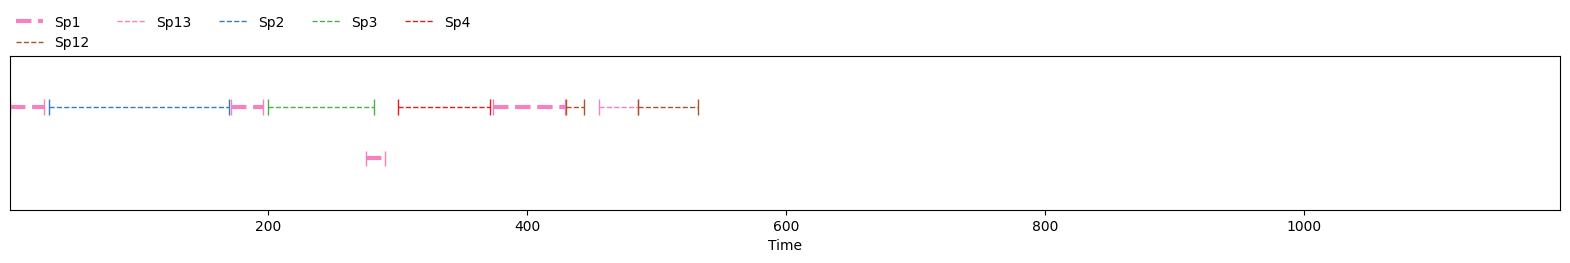

In [81]:
reference, ref_df = reference_gen('/content/hindi_annotations1.csv')
#Visualization (Comparing Between Ground Truth and Hypothesis)
reference

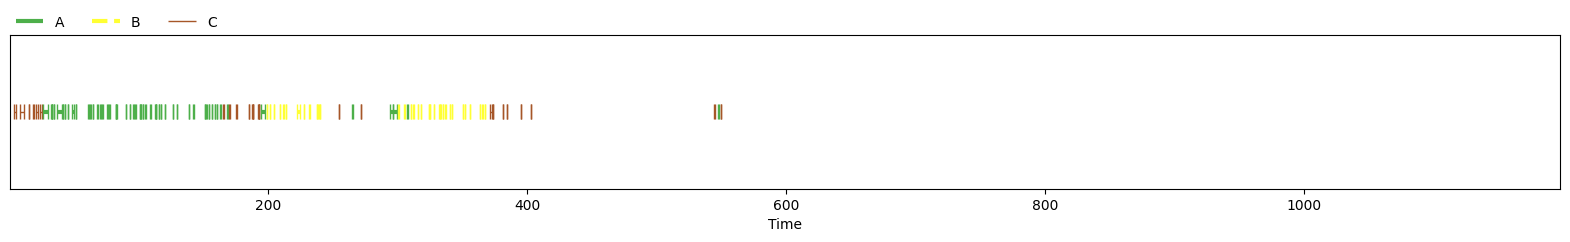

In [82]:
result_hypo

In [83]:
result_ref, ref_df = reference_gen('/content/hindi_annotations1.csv')
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(result_ref, result_hypo)))
#To Evaluate particular Segment of audio-file.
diarizationErrorRate(result_ref, result_hypo, detailed=True, uem=Segment(0, 40))
#Purity
purity = DiarizationPurity()
print("Purity = {0:.3f}".format(purity(result_ref, result_hypo, uem=Segment(0, 40))))
#Coverage
coverage = DiarizationCoverage()
print("Coverage = {0:.3f}".format(coverage(result_ref, result_hypo, uem=Segment(0, 40))))

DER = 0.960
Purity = 0.956
Coverage = 0.956
